In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import pickle
from statsmodels.tsa.api import Holt

In [ ]:
# --- 1. Load Pre-requisites ---

# Load the trained LSTM model and the scaler
print("Loading model and scaler...")
model = load_model('../models/lstm_tesla_forecaster.h5')
with open('../models/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

full_data = pd.read_csv('../data/processed_data.csv', index_col='Date', parse_dates=True)
tsla_prices = full_data[['TSLA']].copy()

look_back = 60 
n_future_days = 270

Loading model and scaler...


In [ ]:
# --- 2. Generate Future Forecast with LSTM ---

print("Generating future forecast with LSTM...")

last_60_days = tsla_prices[-look_back:].values
last_60_days_scaled = scaler.transform(last_60_days)

# Create a placeholder for the future predictions
X_predict = []
X_predict.append(last_60_days_scaled)
X_predict = np.array(X_predict)
# Reshape for the model
X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))

# Generate the first prediction
predicted_price_scaled = model.predict(X_predict)
# Un-scale the prediction
predicted_price = scaler.inverse_transform(predicted_price_scaled)
print(f"First future day prediction: ${predicted_price[0][0]:.2f}")


Generating future forecast with LSTM...


c:\Users\Bisrat\Desktop\KAIM\GMF investment\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
First future day prediction: $310.02


In [7]:
# --- 3. Generate Forecast & Confidence Intervals with Holt's Model ---

print("Generating forecast and confidence intervals with Holt's model...")
holt_model_full = Holt(tsla_prices['TSLA'], exponential=True, initialization_method="estimated").fit()
holt_forecast = holt_model_full.forecast(n_future_days)
forecast_rmse = 17.756361634291977
upper_band = holt_forecast + (1.96 * forecast_rmse)
lower_band = holt_forecast - (1.96 * forecast_rmse)

Generating forecast and confidence intervals with Holt's model...


c:\Users\Bisrat\Desktop\KAIM\GMF investment\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Bisrat\Desktop\KAIM\GMF investment\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Bisrat\Desktop\KAIM\GMF investment\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Visualizing the results...


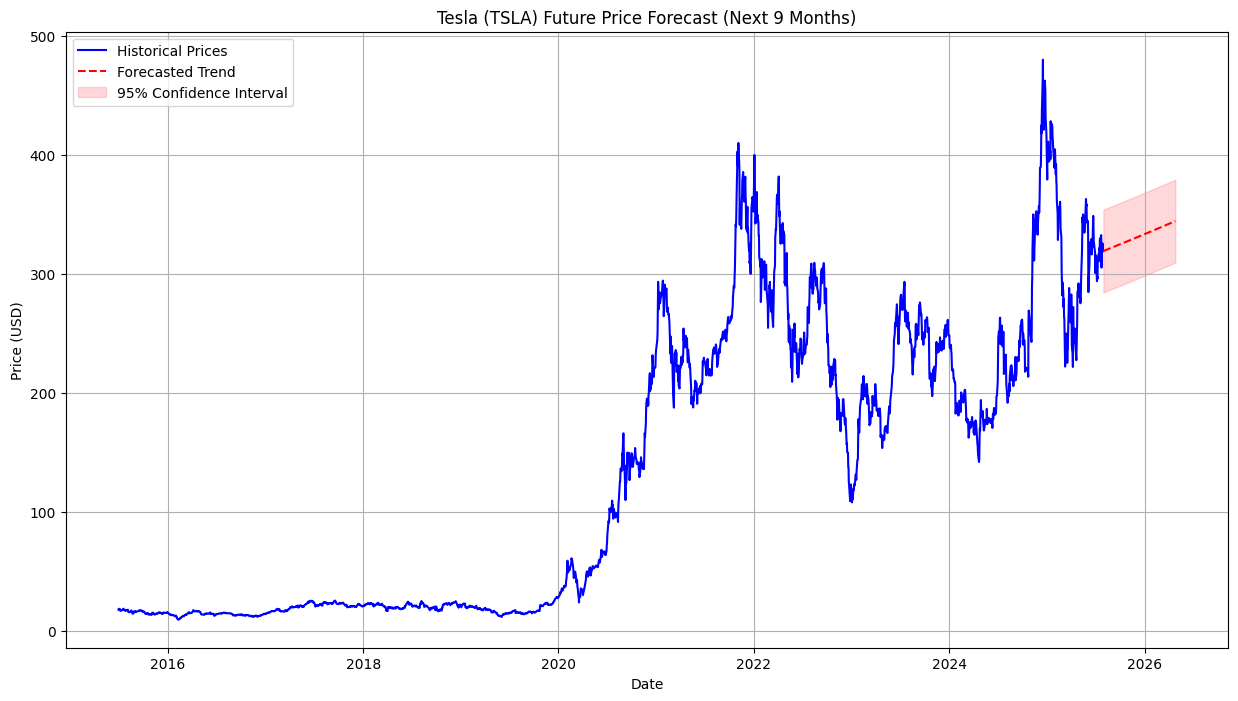

In [8]:
# --- 4. Visualize the Forecast ---

print("Visualizing the results...")

# Create future dates for the x-axis
last_date = tsla_prices.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future_days)

plt.figure(figsize=(15, 8))
plt.title('Tesla (TSLA) Future Price Forecast (Next 9 Months)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')

# Plot historical data
plt.plot(tsla_prices.index, tsla_prices['TSLA'], label='Historical Prices', color='blue')

# Plot the forecasted trend line (from Holt's model)
plt.plot(future_dates, holt_forecast, label='Forecasted Trend', color='red', linestyle='--')

# Plot the confidence interval bands
plt.fill_between(future_dates, lower_band, upper_band, color='red', alpha=0.15, label='95% Confidence Interval')

plt.legend()
plt.grid(True)
plt.show()